### Description:

#### We are putting 10 compartments back to back together and connecting all of them and assigning values to fields such as Ra,Rm and Cm. Note that we find these values by multiplying the specific conductances and capacitances by the area of the compartments. <br><br> All the compartments are passive compartments without any Hodgkin Huxley type channel associated with them. <br><br> The last compartment is treated as the soma.<br><br>We will be injecting current into each compartment using an object with the attributes of the class PulseGen.<br><br>At t=0, we will inject current into the first compartment for say 20ms, then after a break of 20 ms, we will again inject current into the 2nd compartment for 20 ms and so on so forth until we reach the 10th compartment (i.e is the soma).<br><br> All measurements will be done at the soma


In [1]:
import moose
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sim=moose.Neutral('/sim')
model=moose.Neutral('/sim/model')
data=moose.Neutral('/sim/data')
lib=moose.Neutral('/library')

In [3]:
# compartments will be cylindrical
erest=-70e-3
radius=5e-6
length=20e-6
Cm_spec=1e-2
Gm_spec=3
sarea=2*np.pi*radius*length

In [4]:
def get_proto_comp():
    comp_path=f'{lib.path}/comp'
    if moose.exists(comp_path):
        return moose.element(comp_path)

    # We can vary the parameters and see the effects on the membrane potential of the soma
    proto_comp=moose.Compartment(comp_path)
    proto_comp.Rm=1/(3*sarea)
    proto_comp.Cm=1e-2*sarea
    proto_comp.initVm=erest
    proto_comp.Em= -70e-3
    proto_comp.Ra=proto_comp.Rm # value used: Ra=35.4 ohm/cm
    proto_comp.length=length
    proto_comp.diameter=2*radius

    return proto_comp

def get_pulsegen():
    pulsegen_path=f'{lib.path}/pulsegen'
    if moose.exists(pulsegen_path):
        return moose.element(pulsegen_path)

    proto_pulsegen=moose.PulseGen(pulsegen_path)
    proto_pulsegen.level[0]=100e-12
    proto_pulsegen.width[0]=20e-3

    return proto_pulsegen
    # we will set the delay timing in the for loop corresponding to each compartment

In [5]:
proto_comp=get_proto_comp()
proto_pulsegen=get_pulsegen()

In [6]:
# We are setting up 10 compartments and each compartment will have its own pulsegen
comps=[]
pulsegens=[]
pulsegen_tabs=[]
for i in range(0,10):
    comp_hold=moose.copy(proto_comp,model,f'comp_{i}')
    pulsegen_hold=moose.copy(proto_pulsegen,model,f'pulsegen_{i}')
    pulsegen_tab=moose.Table(f'{data.path}/pulsegen_tab_{i}')

    comps.append(comp_hold)
    pulsegens.append(pulsegen_hold)
    pulsegen_tabs.append(pulsegen_tab)
    
    moose.connect(pulsegen_hold,'output',comp_hold,'injectMsg')
    moose.connect(pulsegen_tab,'requestOut',pulsegen_hold,'getOutputValue')

    if len(comps)>1:
        moose.connect(comps[-2],'raxial',comps[-1],'axial')

vm10_tab=moose.Table(f'{data.path}/vm10')
moose.connect(vm10_tab,'requestOut',moose.element(comps[9].path),'getVm')

<moose.SingleMsg id=5 dataIndex=29 path=/Msgs[0]/singleMsg[29]>

In [7]:
for i in range(0,10):
    # setting the pulse gen delays:
    # 20 ms rest and then 20 ms current
    # 40 ms for each pulsegen
    # 400 ms total
    # sim runtime ~~ 450 ms
    n=2*i+1
    moose.element(pulsegens[i].path).delay[0]=(20e-3)*n
    moose.element(pulsegens[i].path).delay[1]=1e9

for i in range(0,10):
    print(moose.element(pulsegens[i].path).delay[0])

0.02
0.06
0.1
0.14
0.18
0.22
0.26
0.3
0.34
0.38


In [8]:
runtime=450e-3
moose.reinit()
moose.start(runtime)

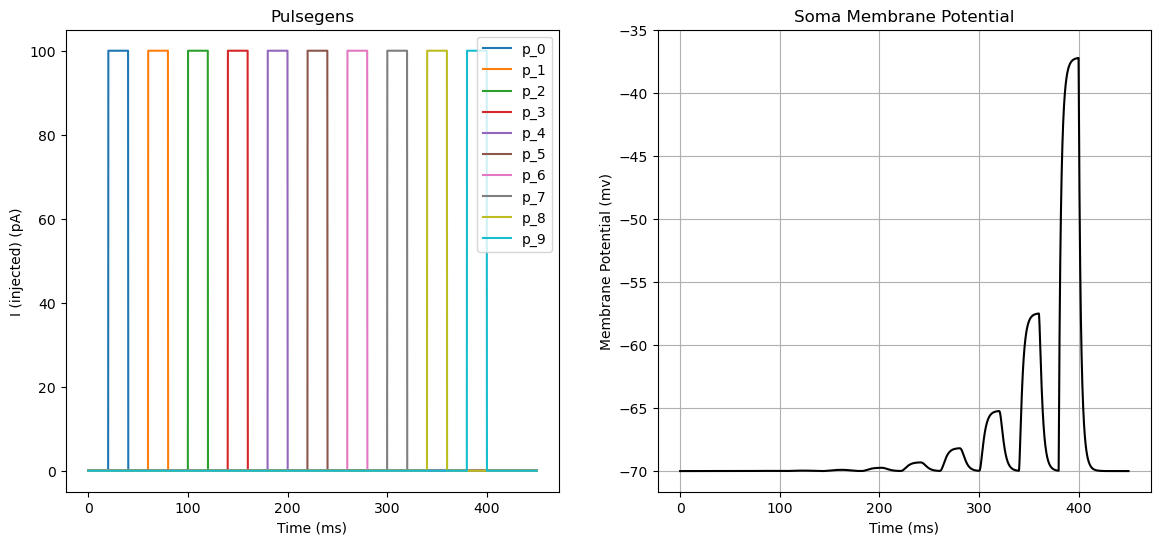

In [9]:
t=np.arange(len(pulsegen_tabs[0].vector))*pulsegen_tabs[0].dt*1e3
fig,axes=plt.subplots(1,2,figsize=(14,6))

for i in range(0,10):
    axes[0].plot(t,pulsegen_tabs[i].vector*1e12,label=f'p_{i}')

axes[0].legend(loc='upper right')
axes[0].set_title('Pulsegens')
axes[0].set_ylabel('I (injected) (pA)')
axes[0].set_xlabel('Time (ms)')

axes[1].plot(t,vm10_tab.vector*1e3,color='black')
axes[1].set_title('Soma Membrane Potential')
axes[1].set_ylabel('Membrane Potential (mv)')
axes[1].set_xlabel('Time (ms)')
axes[1].set_yticks(range(-70,-30,5))
axes[1].grid()

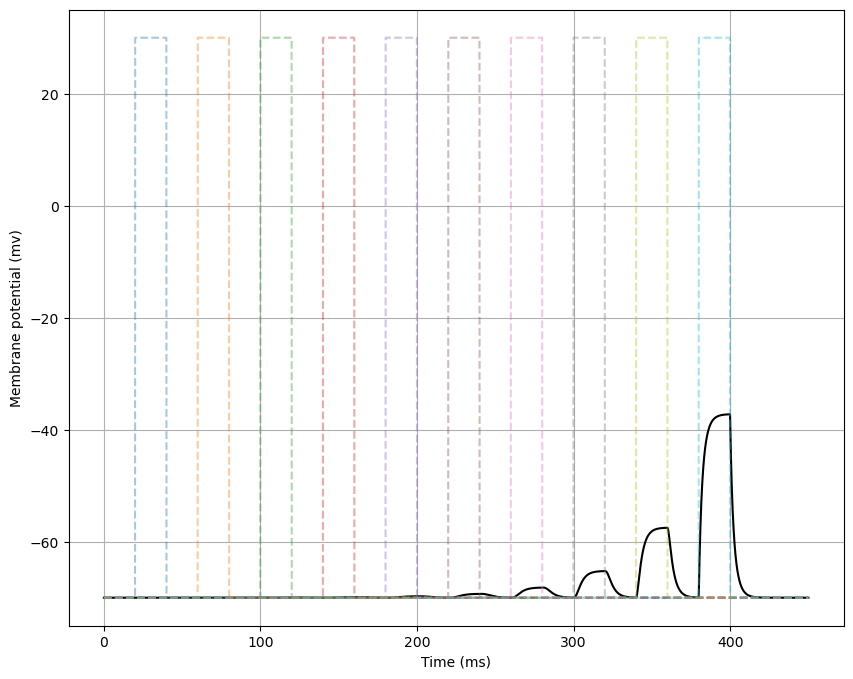

In [10]:
plt.figure(figsize=(10,8))
plt.plot(t,vm10_tab.vector*1e3,color='black')
for i in range(0,10):
    plt.plot(t,pulsegen_tabs[i].vector*1e12-70,'--',alpha=0.4)
plt.ylabel('Membrane potential (mv)')
plt.xlabel('Time (ms)')
plt.grid()
plt.show()

In [11]:
for i in range(9,-1,-1):
    # setting the pulse gen delays:
    # 20 ms rest and then 20 ms current
    # 40 ms for each pulsegen
    # 400 ms total
    # sim runtime ~~ 450 ms
    n=2*i+1
    moose.element(pulsegens[9-i].path).delay[0]=(20e-3)*n
    moose.element(pulsegens[9-i].path).delay[1]=1e9

for i in range(0,10):
    print(moose.element(pulsegens[i].path).delay[0])

0.38
0.34
0.3
0.26
0.22
0.18
0.14
0.1
0.06
0.02


In [12]:
runtime=450e-3
moose.reinit()
moose.start(runtime)

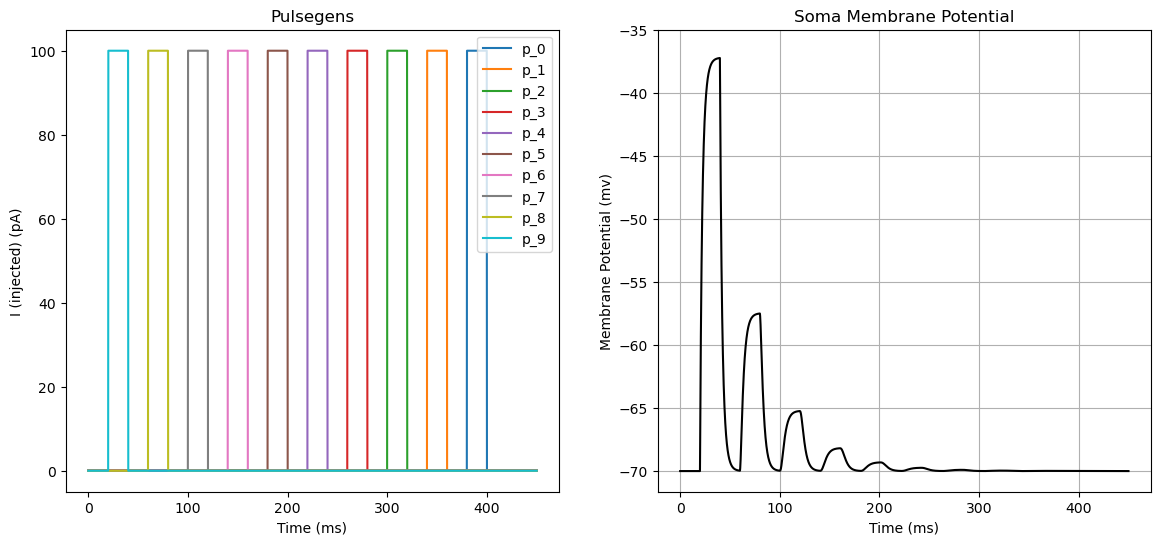

In [13]:
t=np.arange(len(pulsegen_tabs[0].vector))*pulsegen_tabs[0].dt*1e3
fig,axes=plt.subplots(1,2,figsize=(14,6))

for i in range(0,10):
    axes[0].plot(t,pulsegen_tabs[i].vector*1e12,label=f'p_{i}')

axes[0].legend(loc='upper right')
axes[0].set_title('Pulsegens')
axes[0].set_ylabel('I (injected) (pA)')
axes[0].set_xlabel('Time (ms)')

axes[1].plot(t,vm10_tab.vector*1e3,color='black')
axes[1].set_title('Soma Membrane Potential')
axes[1].set_ylabel('Membrane Potential (mv)')
axes[1].set_xlabel('Time (ms)')
axes[1].set_yticks(range(-70,-30,5))
axes[1].grid()

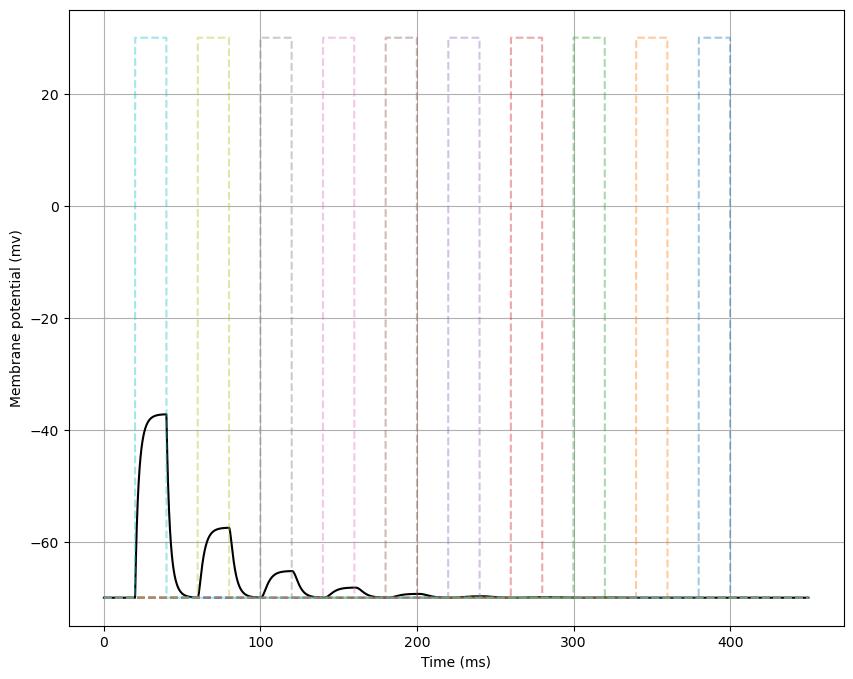

In [15]:
plt.figure(figsize=(10,8))
plt.plot(t,vm10_tab.vector*1e3,color='black')
for i in range(0,10):
    plt.plot(t,pulsegen_tabs[i].vector*1e12-70,'--',alpha=0.4)
plt.ylabel('Membrane potential (mv)')
plt.xlabel('Time (ms)')
plt.grid()
plt.show()